In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [2]:
exchange_data = pd.read_csv('USD_INR.csv')
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

### Real DataFrame

In [3]:
ind_exchange_data.head()

,Price,Open,High,Low,Change %,Class
Date,,,,,,
2017-08-10,64.165,63.898,64.175,63.855,0.48,Test
2017-08-09,63.860,63.780,63.860,63.710,0.26,Test
2017-08-08,63.692,63.750,63.785,63.615,-0.23,Test
2017-08-07,63.840,63.710,63.865,63.648,0.26,Test
2017-08-04,63.675,63.670,63.786,63.572,-0.05,Test


### Reversed and Flipped DataFrame

In [4]:
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Change %,Class,High,Low,Open,Price
Date,,,,,,
1980-01-02,0.00,Train,8.00,8.00,8.00,8.00
1980-01-03,-0.63,Train,7.95,7.95,7.95,7.95
1980-01-04,1.26,Train,8.05,8.05,8.05,8.05
1980-01-07,0.00,Train,8.05,8.05,8.05,8.05
1980-01-08,0.00,Train,8.05,8.05,8.05,8.05


In [5]:
df = data_frame[["Price"]]

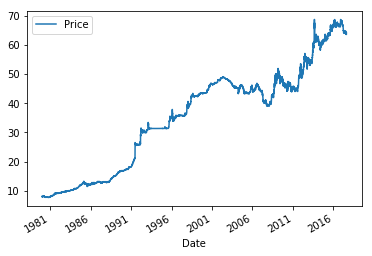

In [6]:
df.plot()

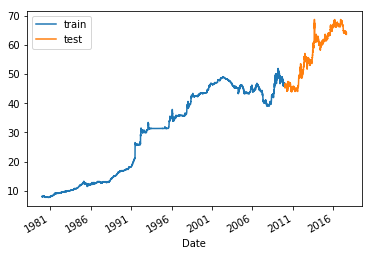

In [7]:
split_date = pd.Timestamp('01-01-2010')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [8]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

# Non-Shifted

## ANN

In [9]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [10]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200
7712/7712 [==============================] - 8s 1ms/step - loss: 2.3960e-05
Epoch 2/200
7712/7712 [==============================] - 8s 1ms/step - loss: 6.2432e-04
Epoch 3/200
7712/7712 [==============================] - 9s 1ms/step - loss: 1.7799e-04
Epoch 00003: early stopping


In [12]:
y_pred_test_ann = model.predict(X_test)
y_train_pred_ann = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_ann)))
r2_train = r2_score(y_train, y_train_pred_ann)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_ann)))
r2_test = r2_score(y_test, y_pred_test_ann)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Train set is:	0.856
The Adjusted R2 score on the Train set is:	0.856

The R2 score on the Test set is:	0.787
The Adjusted R2 score on the Test set is:	0.787


In [18]:
model.save('ANN_NonShift.h5')

### Process the data for LSTM

In [13]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## LSTM

In [15]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

Epoch 1/200
7712/7712 [==============================] - 20s 3ms/step - loss: 1.3438e-05
Epoch 2/200
7712/7712 [==============================] - 19s 3ms/step - loss: 1.1315e-04
Epoch 3/200
7712/7712 [==============================] - 18s 2ms/step - loss: 4.7274e-05
Epoch 4/200
7712/7712 [==============================] - 18s 2ms/step - loss: 2.9131e-05
Epoch 5/200
7712/7712 [==============================] - 17s 2ms/step - loss: 2.3614e-05
Epoch 6/200
7712/7712 [==============================] - 18s 2ms/step - loss: 1.9989e-05
Epoch 00006: early stopping
The R2 score on the Train set is:	0.978
The Adjusted R2 score on the Train set is:	0.978

The R2 score on the Test set is:	0.903
The Adjusted R2 score on the Test set is:	0.903


In [31]:
model_lstm.save('LSTM_NonShift.h5')

## Predictions made by each Model

In [16]:
model_ann = load_model('ANN_NonShift.h5')
model_lstm = load_model('LSTM_NonShift.h5')

/anaconda2/lib/python2.7/site-packages/keras/models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [17]:
score_ann= model_ann.evaluate(X_test, y_test, batch_size=1)
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

1984/1984 [==============================] - 2s 887us/step


In [18]:
print('ANN: %f'%score_ann)
print('LSTM: %f'%score_lstm)

ANN: 0.002102
LSTM: 0.000275


In [19]:
y_pred_test_ANN = model_ann.predict(X_test)
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

In [21]:
col1 = pd.DataFrame(y_test, columns=['True'])
col2 = pd.DataFrame(y_pred_test_ANN, columns=['ANN_prediction'])
col3 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])
col4 = pd.DataFrame(history.history['loss'], columns=['Loss_ANN'])
col5 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3, col4, col5], axis=1)
results.to_excel('PredictionResults_ANN-LSTM_NonShift.xlsx')

### ANN's Prediction Visual

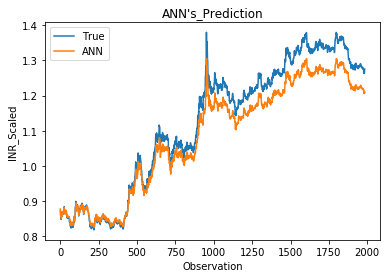

In [33]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ANN, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

### LSTM's Prediction Visual

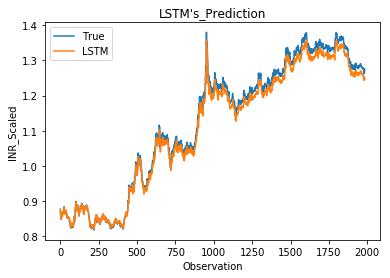

In [35]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()